# Language detection of transliterated text

We can often identify a language being spoken, if we have prior experience of listening that language, even if we do not understand the language at all. Every language has some characteristic sounds (phonemes) patterns. These patterns can be used to identify a language even without understanding them. Automatic Speech/Language Recognition systems use such strings of phonemes as features to identify and understand a language.

Since the keys of the keyboard are generally in English, it is often convenient for non-roman language speakers to transliterate their texts to English than typing in their native scripts. However, for people who not speak that language, it becomes even hard to identify the language without its actual script. Such transliterated content become encripted to the people who don't speak that language, say some YouTube comments etc.

However, like speech if transliterated texts could be pronounced correctly (as in their native langauge), one might be able to identify the language. Fortunately, when any text is transliterated from one langauge to other, it is generally spelled out phonetically. So, if we were to phonetically pronounce the transliterated words, we might be quite closer to its actual pronounciation. 

In this project, I attempt to address this problem by designing an ML sytem which can detect the language of the transliterated text. Due to lack of time to invest at the moment in this project, I confine the scope of this project by just designing a classifier to classify between Korean and Bangla (Bengali) language. For full disclosure, let me explain my choice of these two non-roman languages. I had a personal interest to make machines identify Bangla as it is my mother tongue, spoken mostly in the state of West Bengal in India and in Bangladesh. Lately I have been listening to some Kpop (Korean pop) songs, and considering Kpop's international reach these days, I was tempted to choose Korean as the other langauge.

In future, I might start adding other non-roman languages to the classifier.

# Scrape data

Song lyrics website often transliterate songs in English (perhaps for international audiences). So, for Korean and Bangla (Bengali) sentences transliterated in English, the song lyrics on the following lyrics websites were scraped:
 - bangla lyrics: http://www.lyricsbangla.com/
 - korean lyrics: https://romanization.wordpress.com/

In [1]:
from urllib.request import urlopen
from bs4 import BeautifulSoup
import re

Since the objects in Bengal (referred as Bangla henceforth) and Korean texts might be different created two separate functions to fetch respective text. The different functions are just for cleanliness purpose.

### Functions for scraping Korean transliterated texts

In [3]:
def fetch_korean(fname):
    #some browsing revealed there are 1087 pages (@29th July, 2019) indexed 0 through 1086 with links to lyrics
    #extracting the song links from each of these pages
    npages = 1087
    lyricsbag = open(fname, 'w')
    count = 0
    for pg in range(npages):
        soup = BeautifulSoup(urlopen("https://romanization.wordpress.com/page/%i"%pg), 'html.parser')
        links = soup.find_all('a')
        pageurls = [_.get('href') for _ in links if (_.text == 'Continue reading →')]
        for url in pageurls:
            b = koreanLyrics(url)
            [lyricsbag.write(_+"\n") for _ in b]
            count += 1
            print(count)
    
    return


In [4]:
def koreanLyrics(url):
    s = BeautifulSoup(urlopen(url), 'html.parser')
    lblob = [_.text for _ in s.find_all('p')]
    lyrics = []
    pendown = False
    for _ in lblob:
        if pendown:
            if (_ == "//"):
                pendown = False
                break
            else:
                lyrics += _.split("\n")
        else:
            if "to see the lyrics" in _:
                pendown = True
    return lyrics

### Functions for scraping Bangla transliterated texts

In [5]:
def fetch_bangla(fname):
    #url = "http://www.lyricsbangla.com/?sec=listing&lyricid=4140"
    url = "file:///home/sourav/MLProjects/transliterate/Lyrics%20Search%20»%20LyricsBangla.com.html" 
    #TODO replace the static page with dynamic link smh
    #"http://www.lyricsbangla.com/index.php?sec=search"
    html = urlopen(url)

    soup = BeautifulSoup(html, 'html.parser')
    b = soup.find('table')
    urltable = b.find_all('td')
    
    #extracting songs from links in www.lyricsbangla.com index page
    lyricsurllist = []
    lyricsbag = open(fname, 'w')
    count = 0
    for u in urltable:
        if (u.find('a') != None):
            songlink = u.a.get('href')
            if ("artist" not in songlink):
                b = banglaLyrics(songlink)
                [lyricsbag.write(_+"\n") for _ in b]
                count += 1
                print(count)
        
    return
    

Bangla lyrics often have chords, so here is a list of chords to clean the text scraped from: https://www.pianochord.org/ and saved in "chords.txt"

In [6]:
##(source: https://www.pianochord.org/)
def get_musicalchords():
    chords_ = []
    f = open("chords.txt", 'r')
    lines = f.readlines()
    for l in lines:
        chords_ += l.strip().split()

    return chords_

In [7]:
def banglaLyrics(url):
    spchar = re.compile('[@_!#$%^&*()<>?/\|}{~:]')


    s = BeautifulSoup(urlopen(url), 'html.parser')
    lblob = s.find('p', id='tabs-1')
    lyrics = []
    chord_ = get_musicalchords()
    for line in lblob:
        if (line.string != None):
            l = str(line)
            if any(chord in l for chord in chords_):
                continue
            elif (spchar.search(l)!=None):
                continue
            else:
                l = l.strip()
                if (l): lyrics.append(l)
    return lyrics

The following cell scrapes Bangla and Korean lyrics respectively using the functions defined above.

In [145]:
banglacorpus = "banglacorpus.txt"
fetch_bangla(banglacorpus)


koreancorpus = "koreancorpus.txt"
fetch_korean(koreancorpus)


# Data Cleaning

- make all text lower case in vim for both Bangla and Korean (done in vim. Maybe do in the cleaning script itsel for later projects)
- search for some common words like - "you","love", "it", "will" and remove those lines
- Also, Korean text has this block "Fill in your details below or click an icon to log in:
                        You are commenting using your WordPress.com account.
                        You are commenting using your Google account.
                        You are commenting using your Twitter account.
                        You are commenting using your Facebook account." remove that
 
- koreancorpus.txt -(cleaner_koreancopus.py)-> cleanedkoreancorpus.txt 
- banglacorpus.txt -(cleaner_banglacopus.py)-> cleanedbanglacorpus.txt

"cleanedkoreancorpus.txt" and "cleanedbanglacorpus.txt" are the cleaned corpuses for Korean and Bangla transliterated text used for the analysis

<div style="text-align: right"> "Cleaning is messy!!" ~Anonymous </div>

TODO:
* later add all this cleaning to this notebook
- should store in dataframe

# Data Visualization for encoding

While transliteration, words are spelled phonetically. So, if one spells the transliterated word phonetically, one might actually get quite close to the actual pronounciation in its native language.
If the transliterated words are, therefore, split into phonetic syllables, a list of those phonetic syllables could represent the pronounciation of that word and thus information about its native language. These phonetic syllables are quite analogous to phoneme sequences used in ASR (Automatic Speech Recognition).

Since English is not a phonetic language, its syllables are not phonetic. However, with we try to split the word using a phonetic language, like Italian, then the syllables would indeed be phonetic.

I use a python package - 'pyphen' (https://pyphen.org) for such syllable splitting. This package provides an option to choose the language in which the user wants to split the word. As discussed above, I used Italian, a phonetic language, to split the word into syllables, so that I get phonetic syllables.

Installing pyphen:

In [8]:
# Install pyphen in the current Jupyter kernel
import sys
!{sys.executable} -m pip install pyphen

  Using cached https://files.pythonhosted.org/packages/15/82/08a3629dce8d1f3d91db843bb36d4d7db6b6269d5067259613a0d5c8a9db/Pyphen-0.9.5-py2.py3-none-any.whl


The function below splits the words phonetically (as in italian) into list of syllables to be used as input features for langauge detection:

In [9]:
def wordbagmaker(corpusfilename, label):
   f = open(corpusfilename, 'r')
   lines = f.readlines()

   import random
   import pyphen
   worddict = []
   dic = pyphen.Pyphen(lang='it_IT')
   for l in lines:
       words = l.split()
       if (len(words) < 2): continue #only words present in sentences used, not single word sentences
       for w in words:
          if (len(w) > 1) and w.isalpha(): #words with digits not used and single letter words not used
              worddict.append(dic.inserted(w) + " : " + label)

   random.shuffle(worddict)   #shuffle the list
   return worddict

The words split into phonetic syllables are stored in koreanwordbag.txt and banglawordbag.txt for Korean and Bangla resp. and used to train and test the langauge detection model.

In [10]:
foK = open("koreanwordbag.txt", 'w')
[foK.write(wK+"\n") for wK in wordbagmaker("cleanedkoreancorpus.txt", "K")]
foK.close()
foB = open("banglawordbag.txt", 'w')
[foB.write(wB+"\n") for wB in wordbagmaker("cleanedbanglacorpus.txt", "B")]
foB.close()

In [2]:
fkor = open("koreanwordbag.txt", 'r')
fban = open("banglawordbag.txt", 'r')
datakor = fkor.readlines()
databan = fban.readlines()

A quick feature visualization to see if simple features, like syllable count per word,have any discriminating power.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
syllables_per_wordKOR = []
letters_per_syllableKOR = []
for dK in datakor:
    w = dK.split(" : ")[0].split("-")
    syllables_per_wordKOR.append(len(w))
    [letters_per_syllableKOR.append(len(_)) for _ in w]

syllables_per_wordBAN = []
letters_per_syllableBAN = []
for dB in databan:
    w = dB.split(" : ")[0].split("-")
    syllables_per_wordBAN.append(len(w))
    [letters_per_syllableBAN.append(len(_)) for _ in w]

syllables_per_word = np.concatenate((syllables_per_wordKOR,syllables_per_wordBAN), axis=0)
letters_per_syllable = np.concatenate((letters_per_syllableKOR, letters_per_syllableBAN), axis=0)

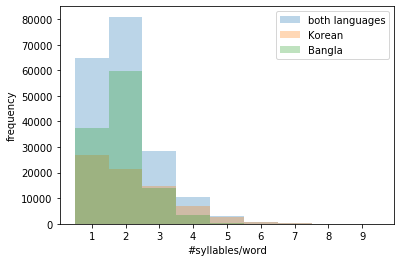

In [5]:
binsSPW = [_ - 0.5 for _ in range(1,11)]
plt.xticks(range(1,11))
plt.hist(syllables_per_word, binsSPW, alpha=0.3, label='both languages')
plt.hist(syllables_per_wordKOR, binsSPW, alpha=0.3, label='Korean') 
plt.hist(syllables_per_wordBAN, binsSPW, alpha=0.3, label='Bangla')

plt.xlabel('#syllables/word')
plt.ylabel('frequency')
plt.legend(loc='best')
plt.show()

Bangla words mostly have 2 syllables, Korean words can have upto 5 syllables in a word. A 10 syllable vector should be enough to encode a word from either language.

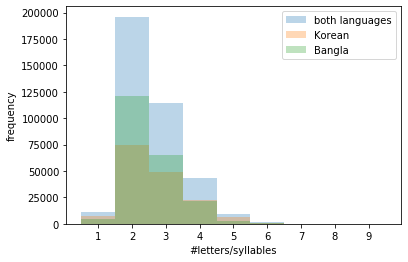

In [6]:
binsLPS = [_ - 0.5 for _ in range(1,11)]
plt.xticks(range(1,11))
plt.hist(letters_per_syllable, binsLPS, alpha=0.3, label='both languages')
plt.hist(letters_per_syllableKOR, binsLPS, alpha=0.3, label='Korean') 
plt.hist(letters_per_syllableBAN, binsLPS, alpha=0.3, label='Bangla')

plt.xlabel('#letters/syllables')
plt.ylabel('frequency')
plt.legend(loc='best')
plt.show()

Most phonetic syllables have around 2 letters. Not a significant disciminator. Would therefore be fair to disregard the syllable length and just integer encode the syllables in both the corpuses.

# Training data

Using 50,000 (10,000) Bangla and Korean words each randomly from the corpuses for training (testing).

In [49]:
import random
Ntrain = 50000
Ntest  = 10000
random.shuffle(datakor) #korean
random.shuffle(databan) #bangla
TrainingVal_data = datakor[:Ntrain] + databan[:Ntrain] 
Testing_data = datakor[Ntrain:Ntrain+Ntest] + databan[Ntrain:Ntrain+Ntest]
random.shuffle(TrainingVal_data)
random.shuffle(Testing_data)

# Word and label encoding

In [44]:
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM

In [50]:
#training data
wordvec = []
labelvec = [] 
for td in TrainingVal_data:
    wvec = []
    tw, tl = td.split(" : ")
    tw = tw.replace("-", " ")
    lvec = [1, 0] if tl.strip() == "B" else [0,1]                #One hot encoding: [1,0] : Bangla, [0,1] : Korean
    wordvec.append(tw)
    labelvec.append(lvec)
labelvec = np.array(labelvec)
print(wordvec[:3])
print(labelvec[:3])


#testing data
wordvec_test = []
labelvec_test = [] 
for td in Testing_data:
    wvec = []
    tw, tl = td.split(" : ")
    tw = tw.replace("-", " ")
    lvec = [1, 0] if tl.strip() == "B" else [0,1]                #One hot encoding: [1,0] : Bangla, [0,1] : Korean
    wordvec_test.append(tw)
    labelvec_test.append(lvec)
labelvec_test = np.array(labelvec_test)


['nae ga', 'ti bro', 'ko nai']
[[0 1]
 [1 0]
 [1 0]]


integer encode the phonetic syllables:

In [51]:
vocab_size = 200000

#training data
print(wordvec[:5])
encoded_docs = [one_hot(d, vocab_size) for d in wordvec]
print(encoded_docs[:5])

#testing data
print(wordvec_test[:5])
encoded_docs_test = [one_hot(d, vocab_size) for d in wordvec_test]
print(encoded_docs_test[:5])


['nae ga', 'ti bro', 'ko nai', 'ka chon', 'na do']
[[34587, 166563], [152402, 80845], [41214, 107601], [85323, 1936], [89525, 136196]]
['na na na na na', 'mae ryeok', 'chad', 'mo tan', 'ne']
[[89525, 89525, 89525, 89525, 89525], [133411, 101737], [117121], [97055, 1854], [122023]]


pad words to a max length of 10 syllables:

In [52]:
max_length = 10

#training data
padded_docs = pad_sequences(encoded_docs, maxlen=max_length, padding='post')
print(padded_docs)

#testing data
padded_docs_test = pad_sequences(encoded_docs_test, maxlen=max_length, padding='post')

[[ 34587 166563      0 ...      0      0      0]
 [152402  80845      0 ...      0      0      0]
 [ 41214 107601      0 ...      0      0      0]
 ...
 [ 85144 183854      0 ...      0      0      0]
 [ 87186  70840      0 ...      0      0      0]
 [  8771 181693      0 ...      0      0      0]]


I train an LSTM to classify Korean and Bangla words, defined below:

In [53]:
lstm_out = 196
# define the model
model = Sequential()
model.add(Embedding(vocab_size, 3, input_length=max_length))
model.add(LSTM(lstm_out, dropout_U=0.2, dropout_W=0.2))
model.add(Dense(2, activation='softmax'))

# compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# summarize the model
print(model.summary())

/usr/lib/python3/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(196, dropout=0.2, recurrent_dropout=0.2)`
  """


Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, 10, 3)             600000    
_________________________________________________________________
lstm_7 (LSTM)                (None, 196)               156800    
_________________________________________________________________
dense_13 (Dense)             (None, 2)                 394       
Total params: 757,194
Trainable params: 757,194
Non-trainable params: 0
_________________________________________________________________
None


train the LSTM:

In [70]:
# fit the model
print(labelvec[:5])
history = model.fit(padded_docs, labelvec, validation_split=0.1, epochs=200, verbose=5)

[[0 1]
 [1 0]
 [1 0]
 [1 0]
 [0 1]]
Train on 90000 samples, validate on 10000 samples
Epoch 1/200
Epoch 2/200
Epoch 3/200
Epoch 4/200
Epoch 5/200
Epoch 6/200
Epoch 7/200
Epoch 8/200
Epoch 9/200
Epoch 10/200
Epoch 11/200
Epoch 12/200
Epoch 13/200
Epoch 14/200
Epoch 15/200
Epoch 16/200
Epoch 17/200
Epoch 18/200
Epoch 19/200
Epoch 20/200
Epoch 21/200
Epoch 22/200
Epoch 23/200
Epoch 24/200
Epoch 25/200
Epoch 26/200
Epoch 27/200
Epoch 28/200
Epoch 29/200
Epoch 30/200
Epoch 31/200
Epoch 32/200
Epoch 33/200
Epoch 34/200
Epoch 35/200
Epoch 36/200
Epoch 37/200
Epoch 38/200
Epoch 39/200
Epoch 40/200
Epoch 41/200
Epoch 42/200
Epoch 43/200
Epoch 44/200
Epoch 45/200
Epoch 46/200
Epoch 47/200
Epoch 48/200
Epoch 49/200
Epoch 50/200
Epoch 51/200
Epoch 52/200
Epoch 53/200
Epoch 54/200
Epoch 55/200
Epoch 56/200
Epoch 57/200
Epoch 58/200
Epoch 59/200
Epoch 60/200
Epoch 61/200
Epoch 62/200
Epoch 63/200
Epoch 64/200
Epoch 65/200
Epoch 66/200
Epoch 67/200
Epoch 68/200
Epoch 69/200
Epoch 70/200
Epoch 71/200


check for overfitting by comparing the validation loss with training loss:

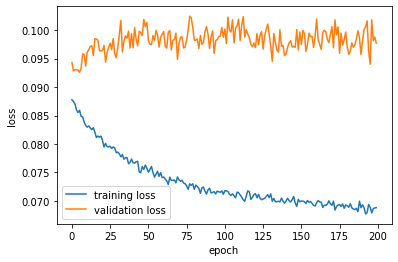

In [73]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training loss', 'validation loss'], loc='best')
plt.show()

The model is clearly overfitting the training data. (Need to resolve soon)

evaluating the LSTM with testing data:

In [76]:
# evaluate the model
loss, accuracy = model.evaluate(padded_docs_test, labelvec_test, verbose=0)
print('Accuracy: %f %%' % (accuracy*100))

Accuracy: 96.330000 %


Conclusion:
   
   The LSTM classifier using phonetic syllables as input features is able to give an accuracy of ~96 %. However, the model seems to be overfitting the training set.

Next steps:
 - Deal with overfitting, by playing with the number of nodes, dropout etc.
 - perform k-fold cross-validation to better estimate classifier performance
 - Draw a ROC of the discriminator output
     - to optimize the cut (aka decision boundary) to discriminate Korean and Bangla, instead of 0.5 (default while calculating accuracy)
     - get the area under the curve (AUROC) to assess the quality of the discriminator
 - Improve cleaning to get rid of non-lexical vocables in the corpus to train a better discriminator
 - Think of a better way to reduce even further English words that are contaminating the corpuses
 - add other non-roman langauges
